##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ベイジアンスイッチポイント解析

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Bayesian_Switchpoint_Analysis"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Bayesian_Switchpoint_Analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Bayesian_Switchpoint_Analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/Bayesian_Switchpoint_Analysis.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このノートブックは、[pymc3 ドキュメント](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters)に含まれるベイズの「Change point analysis」の例を再実装し、拡張したものです。

## 前提条件

In [ ]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd

## データセット

データセットは[こちら](https://pymc-devs.github.io/pymc/tutorial.html#two-types-of-variables)を使用します。この例の別のバージョンが[出回っています](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters)が、データが「欠落」しているため、欠落している値によって問題が起きてしまいます。（そうでなくとも、尤度関数が未定義となるため、モデルは初期パラメータから抜けることができません。）

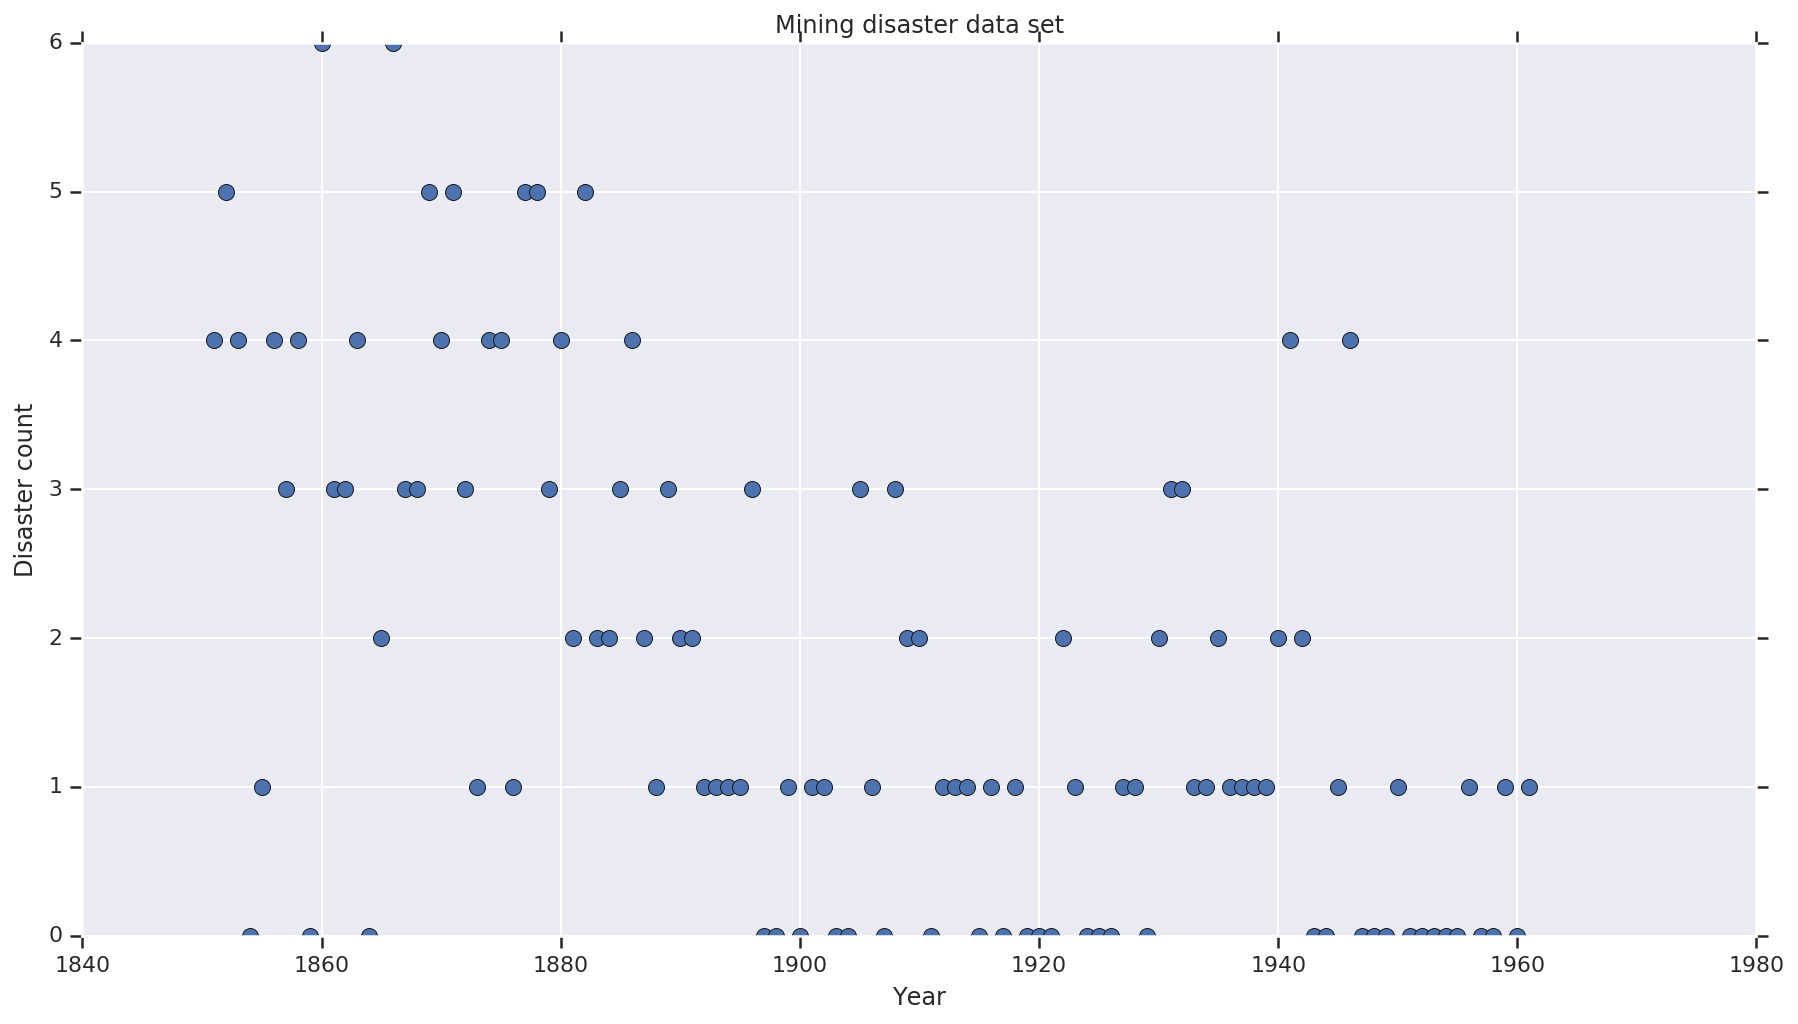

In [ ]:
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)
plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel('Disaster count')
plt.xlabel('Year')
plt.title('Mining disaster data set')
plt.show()

## 確率的モデル

このモデルは、「スイッチポイント」（安全規制が変更される年など）と、一定した（ただし潜在的に異なる）率によるそのスイッチポイントの前と後のポワソン分布の災害発生率を使用します。

実際の災害発生数は固定（観測済み）です。このモデルのすべてのモデルはスイッチポイントと災害の「早期」と「後期」の発生率の両方を指定する必要があります。

[pymc3 ドキュメントの例](https://pymc-devs.github.io/pymc/tutorial.html)に含まれる元のモデル:

$$ \begin{align*} (D_t|s,e,l)&amp;\sim \text{Poisson}(r_t), \ &amp; ,\quad\text{with}; r_t = \begin{cases}e &amp; \text{if}; t &lt; s\l &amp;\text{if}; t \ge s\end{cases} \ s&amp;\sim\text{Discrete Uniform}(t_l,,t_h) \ e&amp;\sim\text{Exponential}(r_e)\ l&amp;\sim\text{Exponential}(r_l) \end{align*} $$

しかし、平均災害発生率 $r_t$ には、スイッチポイント $s$ での不連続点があります。そのため、これは微分不可能です。したがって、ハミルトニアンモンテカルロ（HMC）アルゴリズムに勾配信号は送られません。ただし、$s$ より前は連続であるため、HMC はランダムウォーク（酔歩）にフォールバックします。この例の確立室用の高い領域を見つけるには十分です。

2 つ目のモデルとして、トランジションを微分可能にするために[シグモイド関数の「switch」](https://en.wikipedia.org/wiki/Sigmoid_function)を *e* と *l* の間に使用して元のモデルを変更し、スイッチポイント $s$ の連続一様分布を使用します。（平均発生率の「スイッチ」の期間は何年にもなる可能性があるため、このモデルはより現実的ということもできます。）したがって、新しいモデルは次のようになります。

$$ \begin{align*} (D_t|s,e,l)&amp;\sim\text{Poisson}(r_t), \ &amp; ,\quad \text{with}; r_t = e + \frac{1}{1+\exp(s-t)}(l-e) \ s&amp;\sim\text{Uniform}(t_l,,t_h) \ e&amp;\sim\text{Exponential}(r_e)\ l&amp;\sim\text{Exponential}(r_l) \end{align*} $$

その他の情報がない状態で、$r_e = r_l = 1$ を事前確率のパラメータとして使用します。両方のモデルを実行して、推論の結果を比較してみましょう。

In [ ]:
def disaster_count_model(disaster_rate_fn):
  disaster_count = tfd.JointDistributionNamed(dict(
    e=tfd.Exponential(rate=1.),
    l=tfd.Exponential(rate=1.),
    s=tfd.Uniform(0., high=len(years)),
    d_t=lambda s, l, e: tfd.Independent(
        tfd.Poisson(rate=disaster_rate_fn(np.arange(len(years)), s, l, e)),
        reinterpreted_batch_ndims=1)
  ))
  return disaster_count

def disaster_rate_switch(ys, s, l, e):
  return tf.where(ys < s, e, l)

def disaster_rate_sigmoid(ys, s, l, e):
  return e + tf.sigmoid(ys - s) * (l - e)

model_switch = disaster_count_model(disaster_rate_switch)
model_sigmoid = disaster_count_model(disaster_rate_sigmoid)

上記のコードは、JointDistributionSequential 分布を介してモデルを定義しています。`disaster_rate` 関数は、`[0, ..., len(years)-1]` の配列とともに呼び出され、`len(years)` ランダム変数のベクトルを生成します。（シグモイドトランジションを法として）`switchpoint` より前の年は `early_disaster_rate` で、後の年は `late_disaster_rate` です。

健全性チェックは次のとおりになります。ターゲットの対数確率関数は健全です。

In [ ]:
def target_log_prob_fn(model, s, e, l):
  return model.log_prob(s=s, e=e, l=l, d_t=disaster_data)

models = [model_switch, model_sigmoid]
print([target_log_prob_fn(m, 40., 3., .9).numpy() for m in models])  # Somewhat likely result
print([target_log_prob_fn(m, 60., 1., 5.).numpy() for m in models])  # Rather unlikely result
print([target_log_prob_fn(m, -10., 1., 1.).numpy() for m in models]) # Impossible result

[-176.94559, -176.28717]
[-371.3125, -366.8816]
[-inf, -inf]


## HMC でベイジアン推論を行う

結果数と必要なバーンインステップを定義します。このコードはほぼ、[tfp.mcmc.HamiltonianMonteCarlo のドキュメント](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo)を模倣したものです。適応ステップサイズを使用しています（そうでなければ、結果は選択されたステップサイズ値の影響を大きく受けるためです）。チェーンの初期状態として 1 の値を使用します。

ただし、これは完全なストーリーではありません。上記のモデル定義に戻ると、一部の確率分布は実数線全体においてうまく定義されていません。したがって、HMC カーネルを前方 Bijector を指定する [TransformedTransitionKernel](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/TransformedTransitionKernel) でラップして実数を確率分布が定義されている領域に変換することで、HMC が調べる空間を制約します（以下のコードのコメントをご覧ください）。

In [ ]:
num_results = 10000
num_burnin_steps = 3000

@tf.function(autograph=False, jit_compile=True)
def make_chain(target_log_prob_fn):
   kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3),
       bijector=[
          # The switchpoint is constrained between zero and len(years).
          # Hence we supply a bijector that maps the real numbers (in a
          # differentiable way) to the interval (0;len(yers))
          tfb.Sigmoid(low=0., high=tf.cast(len(years), dtype=tf.float32)),
          # Early and late disaster rate: The exponential distribution is
          # defined on the positive real numbers
          tfb.Softplus(),
          tfb.Softplus(),
      ])
   kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps))

   states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          tf.ones([], name='init_switchpoint'),
          tf.ones([], name='init_early_disaster_rate'),
          tf.ones([], name='init_late_disaster_rate'),
      ],
      trace_fn=None,
      kernel=kernel)
   return states

switch_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]

switchpoint, early_disaster_rate, late_disaster_rate = zip(
    switch_samples, sigmoid_samples)

両方のモデルを並行して実行します。

## 結果を視覚化する

結果は、早期と後期の災害発生率を表す事後確率分布のサンプルとスイッチポイントを含むヒストグラムとして視覚化します。ヒストグラムには、サンプルの中央値を表す実線と、95 パーセンタイルの信頼区間の境界を表す破線をオーバーレイします。

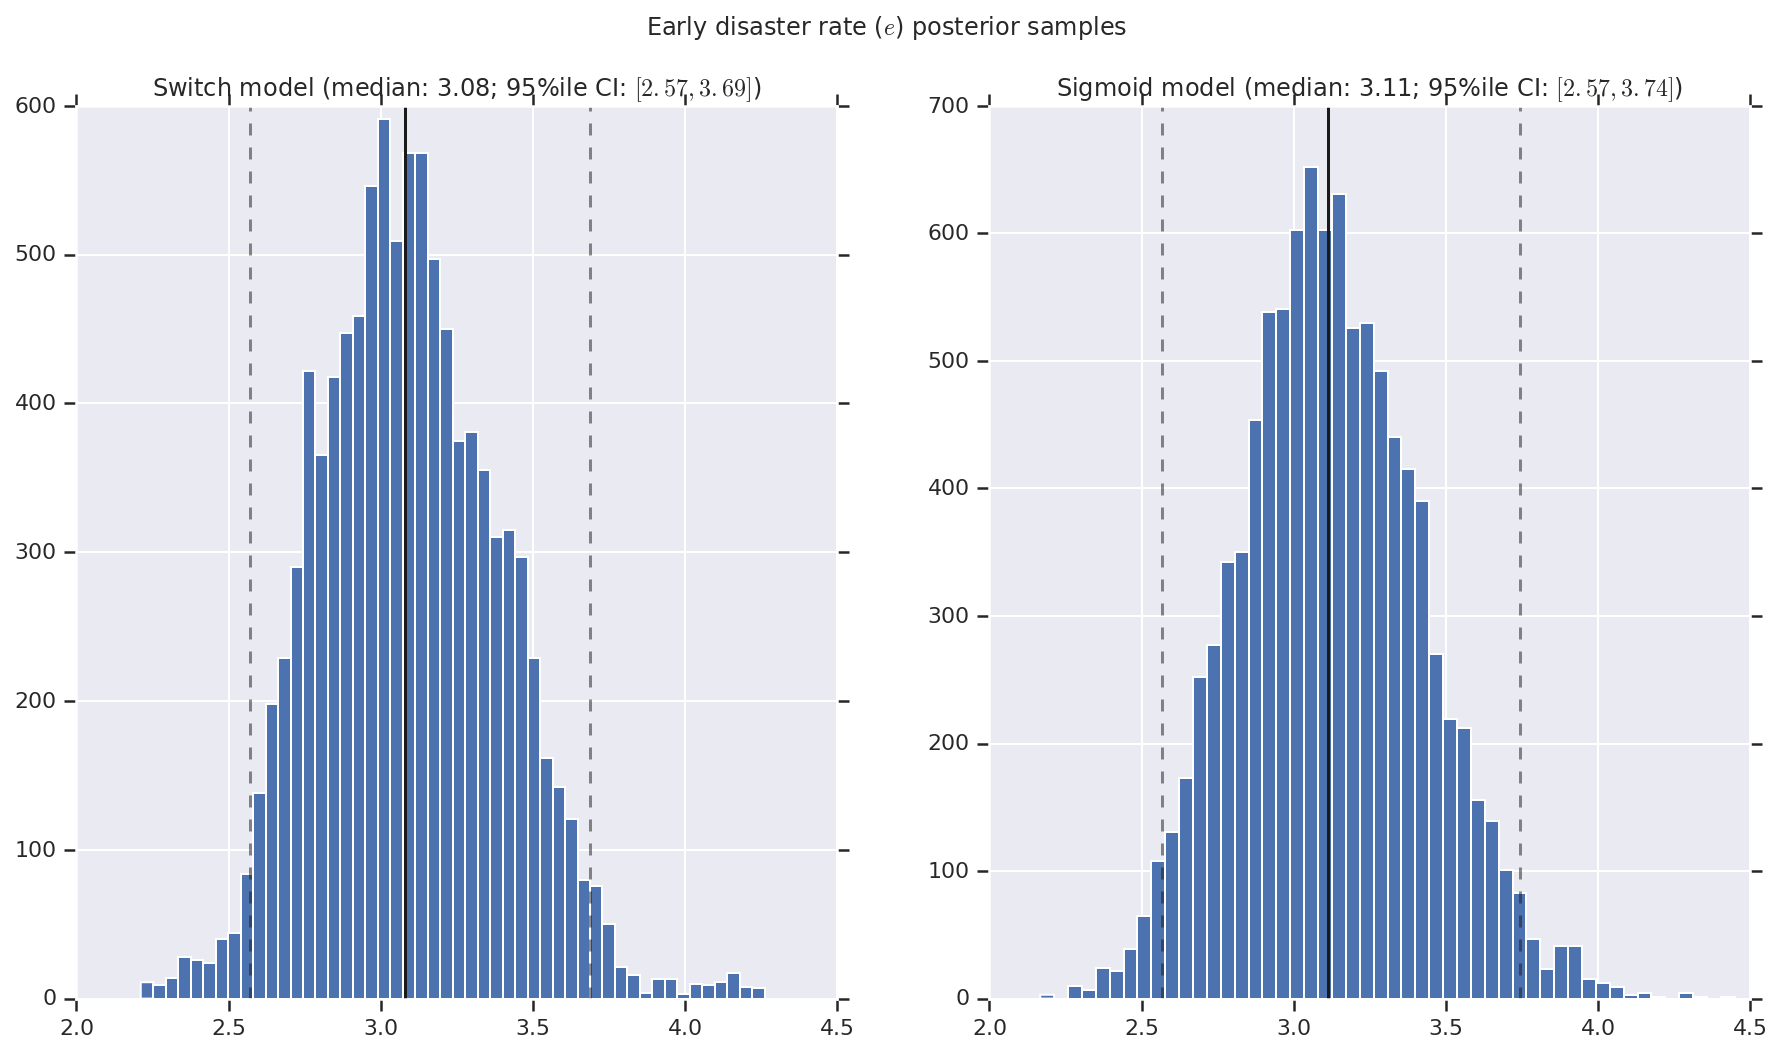

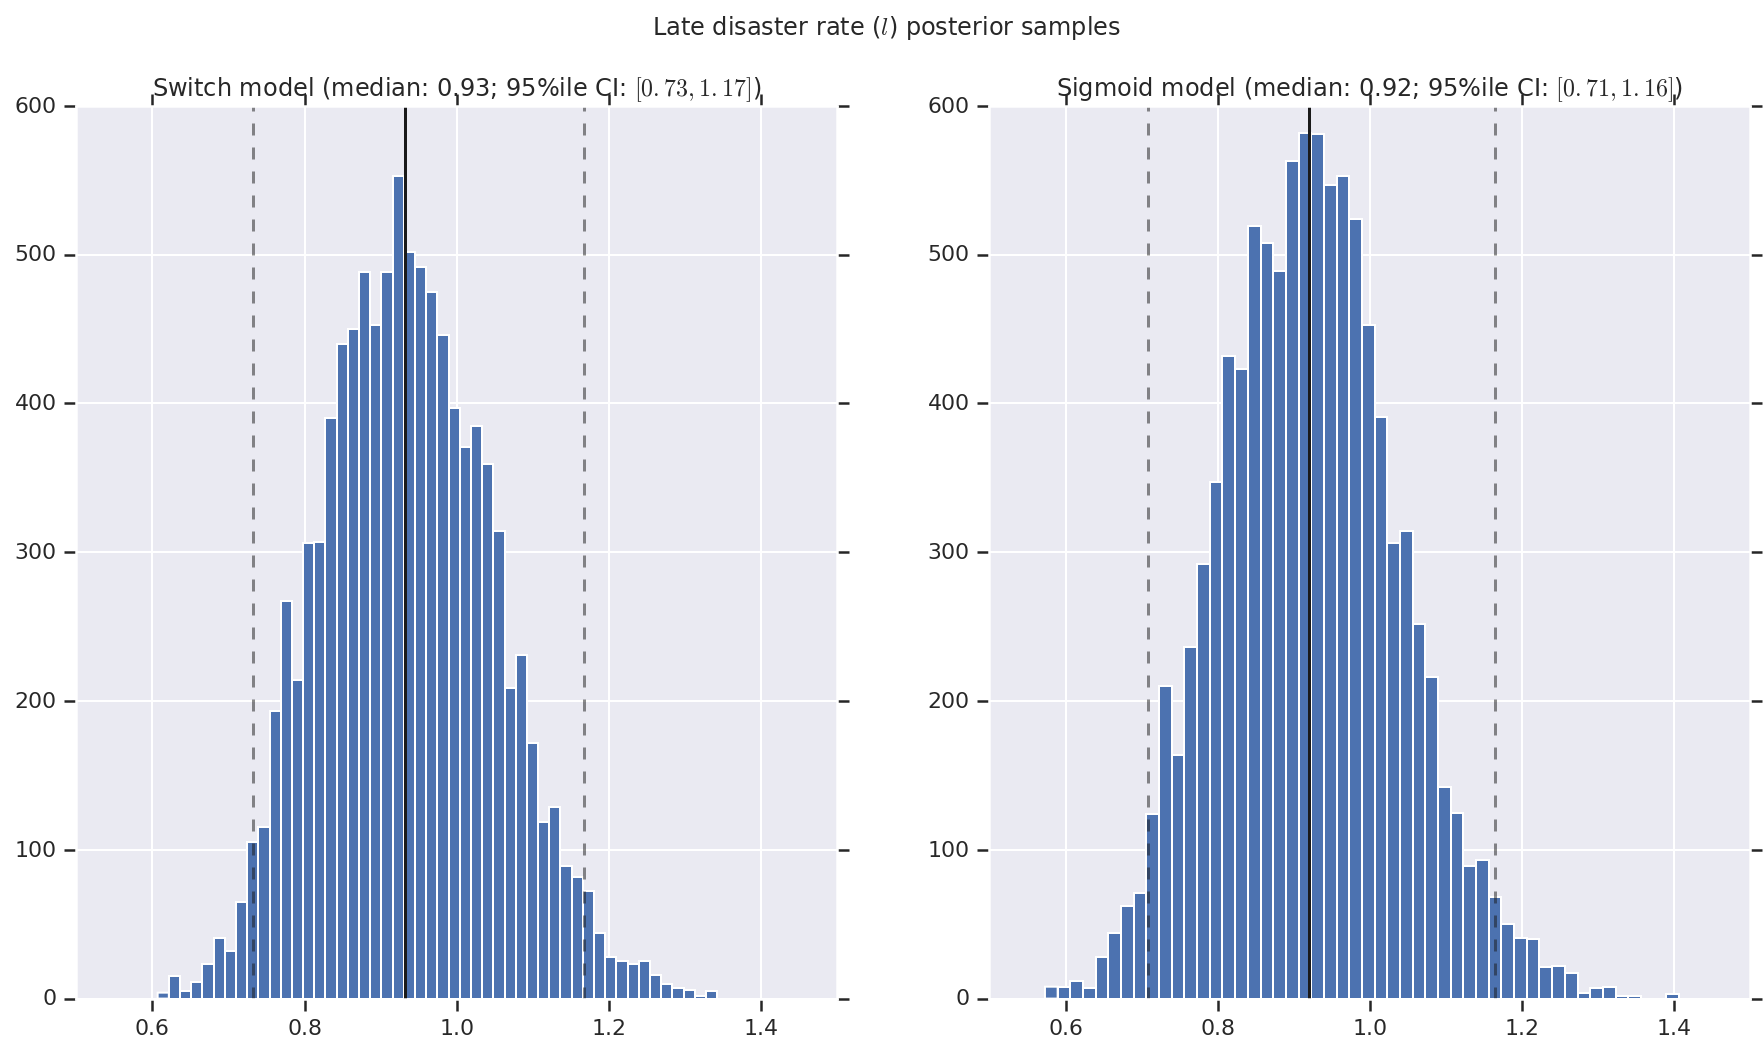

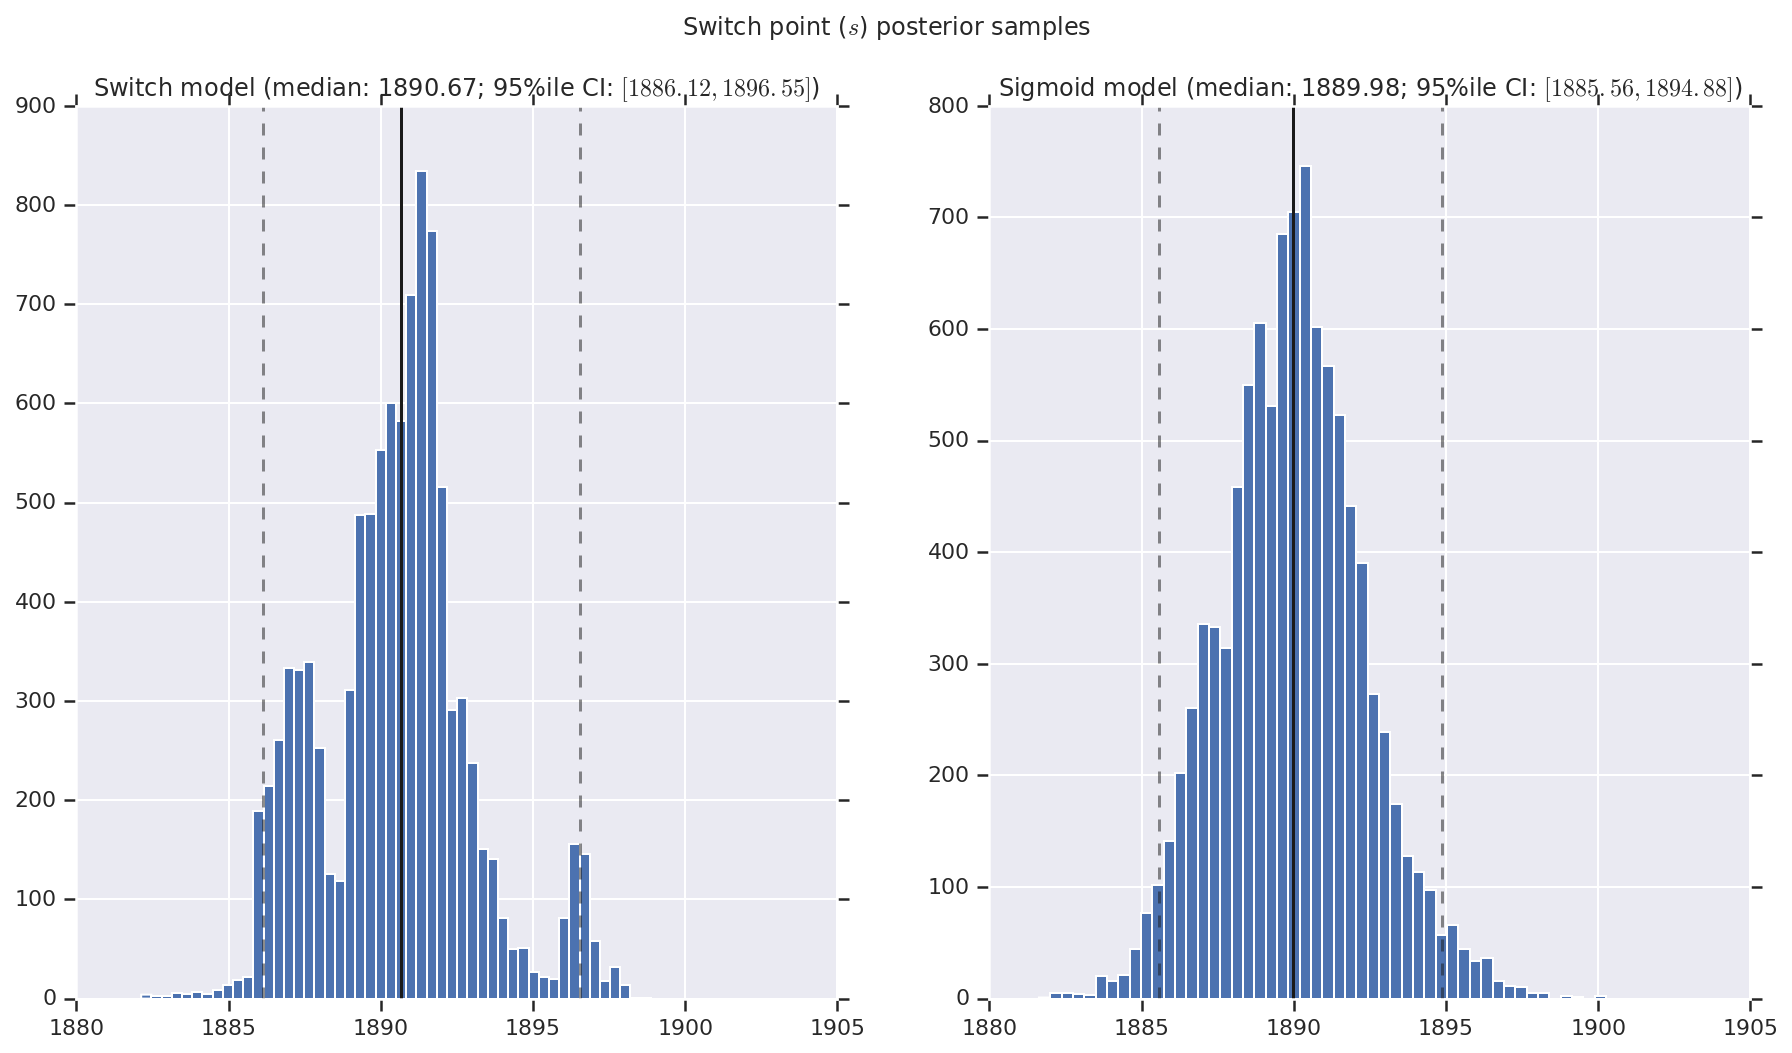

In [ ]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(
      *np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [
    ('Early disaster rate ($e$) posterior samples', early_disaster_rate),
    ('Late disaster rate ($l$) posterior samples', late_disaster_rate),
    ('Switch point ($s$) posterior samples', years[0] + switchpoint),
]:
  fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
  for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
    a = ax[i]
    a.hist(v[i], bins=50)
    a.axvline(x=np.percentile(v[i], 50), color='k')
    a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
    a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
    a.set_title(m + ' model ' + _desc(v[i]))
  fig.suptitle(t)
  plt.show()